In [19]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
sp.init_printing()

import trajectories
import ekf
import functools
import scipy.optimize


In [2]:
# defines a few variables
x, y= sp.symbols('x y')
state = sp.Matrix([x, y])
dt = sp.symbols('Delta_t')
b_x, b_y = sp.symbols('b_x b_y') # beacon position

In [3]:
g = state
h_b = sp.Matrix([sp.sqrt((x - b_x)**2 + (y - b_y)**2)])
BEACON_POS = [
    (-1.5, 0),
    (1.5, 1),
    (1.5, -1),
]

In [26]:
def simulate_trajectory(process_variance, measurement_variance, f=10, N=1000):
    # Empty control input
    u = sp.Matrix([])

    # Prepares the numerical version of the update functions
    g_num = sp.lambdify([state, u], g, 'numpy')
    G_num = sp.lambdify([state, u], g.jacobian(state), 'numpy')
    h_num = sp.lambdify([[b_x, b_y], state], h_b, 'numpy')
    H_num = sp.lambdify([[b_x, b_y], state], h_b.jacobian(state), 'numpy')

    # Sample covariance for the model
    Q_b = np.array([[measurement_variance]])
    R = np.eye(2) * process_variance

    # Prepare the kalman filter
    predictor = ekf.Predictor(g_num, G_num, R)
    correctors = [
        ekf.Corrector(functools.partial(h_num, pos),
                      functools.partial(H_num, pos),
                      Q_b
                     )
    for pos in BEACON_POS]

    mu = np.array([0, 0]) # initial state
    sigma = np.diag([1, 1])

    x, xhat = [], []
    y, yhat = [], []
    ts = []

    for i, p in zip(range(N), trajectories.generate_circular_traj(1, np.deg2rad(10), 1/f)):
        # feeds the input into Kalman
        filter_input = np.array([])

        mu, sigma = predictor(mu, sigma, filter_input)
        for corrector in correctors:
            z = corrector.h(np.array([p.pos[0], p.pos[1]]))
            z += np.random.normal(0, 0.01)
            mu, sigma = corrector(mu, sigma, z)

        # Saves the data
        ts.append(p.timestamp)
        x.append(p.pos[0])
        xhat.append(mu[0])
        y.append(p.pos[1])
        yhat.append(mu[1])
        
    return ts, x, y, xhat, yhat

In [48]:
ts, x, y, xhat, yhat = simulate_trajectory(process_variance=0.1**2, measurement_variance=0.03**2)

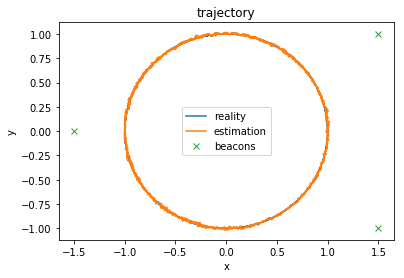

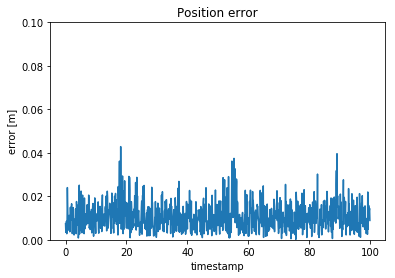

In [49]:
plt.plot(x, y)
plt.plot(xhat, yhat)
plt.plot([x for x, y in BEACON_POS],[y for x, y in BEACON_POS], 'x')
plt.legend(('reality', 'estimation', 'beacons'))
plt.title('trajectory')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.plot(ts, [np.sqrt((x-xh)**2+(y-yh)**2) for x,xh,y,yh in zip(x, xhat,y,yhat)])
plt.xlabel('timestamp')
plt.ylabel('error [m]')
plt.ylim(0, 0.1)
plt.title('Position error')
plt.show()

In [29]:
def cost(variances):
    process_variance = variances[0]
    measurement_variance = variances[1]
    _, x, xh, y, yh = simulate_trajectory(process_variance, measurement_variance, N=100)
    
    return sum(np.sqrt((x-xh)**2+(y-yh)**2) for x,xh,y,yh in zip(x, xhat,y,yhat))

In [35]:
x0 = np.array([0.1**2, 0.03**2])
cost(x0)

array([ 58.09280195])

In [50]:
# We tried to optimize it but its not very efficient
# scipy.optimize.basinhopping(cost, x0, niter=10)